# IS424: Data Mining & Biz Analytics
## Team: G3T3
### Project: Predicting Loan Default based on Customer Profile
### Data Preprocessing
---

# 1. Setting up the notebook
---

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

### Import dataset and tidy columns

In [2]:
df = pd.read_csv("./dataset/loanprediction.csv")
df.drop("Id", axis=1, inplace=True)

In [3]:
# standardise column naming
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]

In [4]:
# retrieve numerical and categorical columns
numerical = list(df.describe().columns)[:-1]
categorical = [i for i in df.columns if i not in numerical and i != "risk_flag"]

In [5]:
numerical

['income', 'age', 'experience', 'current_job_years', 'current_house_years']

### Splitting the data into train and test splits

In [6]:
x = df.drop("risk_flag", axis=1)
y = df["risk_flag"]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

# 2. Feature Engineering
---

## 2.1 Label and One Hot Encoding

In [8]:
def feature_engineering(df_x, df_y):
    """
        Encoding categorical columns
    """
    x = df_x.copy()
    
    # Label/Binary Encoding — categorical columns with binary categories
    label_enc = LabelEncoder()
    x["marital_status"] = label_enc.fit_transform(x["marital_status"])
    x["car_ownership"] = label_enc.fit_transform(x["car_ownership"])
    
    
    # One Hot Encoding — house_ownership column
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    house_ownership_values = onehot_encoder.fit_transform( x[['house_ownership']] )
    house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
    house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

    x.reset_index(drop=True, inplace=True)
    house_ownership_df.reset_index(drop=True, inplace=True)
    x = pd.concat([x, house_ownership_df], axis=1)
    
    x.drop("house_ownership", axis=1, inplace=True)

    return x

x_train = feature_engineering(x_train, y_train)
x_test = feature_engineering(x_test, y_test)

## 2.2 Target Encoding
Target Encoding is carried on categorical columns with high cardinality: `profession`, `city`, `state` to prevent a blow up in dimensionality due to encoding techniques like One Hot Encoding.


Note: Feature engineering using Target Encoding will be carried out at the Grid Search Cross-Validation step to prevent data leakage. This function will be imported into the respective notebooks.

In [9]:
def target_encoding(df_x, df_y):
    x = df_x.copy()
    
    # Target Encoding — categorical columns with high cardinality: profession, city, state
    profession_target_enc = TargetEncoder()
    x["profession_encoded"] = profession_target_enc.fit_transform(x["profession"], df_y)
    
    city_target_enc = TargetEncoder()
    x["city_encoded"] = city_target_enc.fit_transform(x["city"], df_y)
    
    state_target_enc = TargetEncoder()
    x["state_encoded"] = state_target_enc.fit_transform(x["state"], df_y)
    
    x.drop("profession", axis=1, inplace=True)
    x.drop("city", axis=1, inplace=True)
    x.drop("state", axis=1, inplace=True)
    return x

# 3. Feature Selection
---

To reduce the dimensional space of the dataset, we are carrying out several feature selection techniques with the goal of identify features to keep and drop

1. Filter Methods
    - Chi-square
    - ANOVA
2. Embedded Methods
    - Random Forest
    - XGBoost
    - Lasso Regression  

In [10]:
def retrieve_feature_importance(importance, names):
    """
        Helper function to display the feature importance
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_name':feature_names,'feature_importance':feature_importance}
    feature_importance_df = pd.DataFrame(data)

    feature_importance_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    return feature_importance_df.reset_index(drop=True)

## 3.1 Filter Methods
---
### Chi-square

,feature_name,feature_importance
0,house_ownership,7.283203e-04
1,marital_status,7.167547e-04
2,state,1.661200e-05
3,profession,5.771417e-13
4,car_ownership,6.535069e-24
5,city,1.266794e-63


<AxesSubplot:>

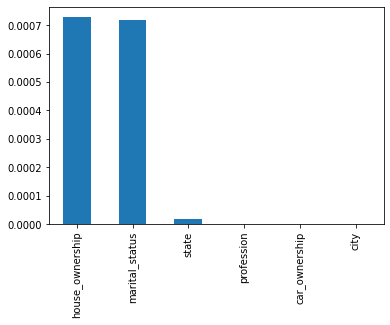

In [11]:
numerical = ["income", "age", "experience", "current_job_years", "current_house_years"]
categorical = ["risk_flag", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state"]

df_cat = df.copy()[categorical]

label_enc = LabelEncoder()
for cat in categorical:
    df_cat[cat] = label_enc.fit_transform(df_cat[cat])
    
y = df_cat["risk_flag"]
x = df_cat.drop("risk_flag", axis=1)

chi_scores = chi2(x, y)

# show results — dataframe
results_df = retrieve_feature_importance(chi_scores[1], x.columns)
display(results_df)

# show results — graph
p_values = pd.Series(chi_scores[1], index = x.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

### ANOVA

In [12]:
# x = df.copy()[numerical]
# fscore = SelectKBest(k="all")
# fscore.fit(x, y)
# x_fs = fscore.transform(x)

# results_df = retrieve_feature_importance(fscore.scores_, x.columns)
# results_df

## 3.2 Embedded Methods
---

Note: Encoding is required for profession, city and state for the purpose of Feature Selection. However, the actual encoding will only be done during GridSearch Cross-Validation

In [13]:
x_train_embedded = target_encoding(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### 3.2.1 Random Forest Classifier

In [14]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=2021)
rf_clf.fit(x_train_embedded, y_train.values.ravel() )

RandomForestClassifier(random_state=2021)

In [15]:
feat_impt_df = retrieve_feature_importance(rf_clf.feature_importances_, x_train_embedded.columns)
feat_impt_df

,feature_name,feature_importance
0,income,0.185485
1,city_encoded,0.159253
2,profession_encoded,0.144572
3,age,0.141265
4,state_encoded,0.104522
5,experience,0.085605
6,current_job_years,0.076982
7,current_house_years,0.064581
8,car_ownership,0.015491
9,marital_status,0.010865


### 3.2.2 XGBoost

In [16]:
xgb = XGBClassifier(use_label_encoder=False,
                    random_state=2021)
                    
xgb.fit(x_train_embedded, y_train)

[13:52:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [17]:
feat_impt_df = retrieve_feature_importance(xgb.feature_importances_, x_train_embedded.columns)
feat_impt_df

,feature_name,feature_importance
0,income,0.097845
1,city_encoded,0.088775
2,rented,0.086748
3,car_ownership,0.083332
4,age,0.083198
5,state_encoded,0.083187
6,profession_encoded,0.081845
7,current_job_years,0.079102
8,experience,0.078977
9,current_house_years,0.074698


### 3.3.3 Lasso Regression

In [18]:
alpha_param = [1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alpha_param:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train_embedded, y_train)

    importance = np.abs( lasso.coef_ )

    feat_impt_df = retrieve_feature_importance(importance, x_train_embedded.columns)
    feat_impt_df.index.rename('alpha='+str(alpha), inplace=True) 
    print( feat_impt_df )
    print()

                feature_name  feature_importance
alpha=1                                         
0                     income        2.780118e-10
1                        age        0.000000e+00
2                 experience        0.000000e+00
3             marital_status        0.000000e+00
4              car_ownership        0.000000e+00
5          current_job_years        0.000000e+00
6        current_house_years        0.000000e+00
7               norent_noown        0.000000e+00
8                      owned        0.000000e+00
9                     rented        0.000000e+00
10        profession_encoded        0.000000e+00
11              city_encoded        0.000000e+00
12             state_encoded        0.000000e+00

                  feature_name  feature_importance
alpha=0.1                                         
0                          age        5.703995e-05
1                       income        2.779366e-10
2                   experience        0.000000e+00
3        

### Conclusion:
Results from the Feature Selection process are consolidated into this Google Sheet: <Insert Link Here>

# 4. Feature Scaling
---

In [19]:
def feature_scaling(df_x):
    x = df_x.copy()
    min_max_scaler = MinMaxScaler()
    x[numerical] = min_max_scaler.fit_transform( x[numerical] )
    return x

x_train = feature_scaling(x_train)
x_test = feature_scaling(x_test)

# 5. Exporting preprocessed Train Test sets to csv files
---

In [20]:
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
train = pd.concat([x_train, y_train], axis=1)

x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
test = pd.concat([x_test, y_test], axis=1)

try:
    train.to_csv("./dataset/train.csv", index=False)
    test.to_csv("./dataset/test.csv", index=False)
    print('Succesfully exported')
except:
    print('Error')

Succesfully exported
